<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/zero2_chap02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import urllib.request

In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split()

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [ ]:
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix


def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [ ]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print(f'{query} is not found')
        return
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f' {id_to_word[i]}: {similarity[i]}')

        count += 1
        if count >= top:
            return

In [ ]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goobye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [ ]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
    
                if cnt % (total//100 + 1) == 0:
                    print(f'{100*cnt/total:.1f} done')
    
    return M

In [ ]:
W = ppmi(C)
np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [ ]:
U, S, V = np.linalg.svd(W)

In [ ]:
print(U[0, :2])

[0.    0.341]


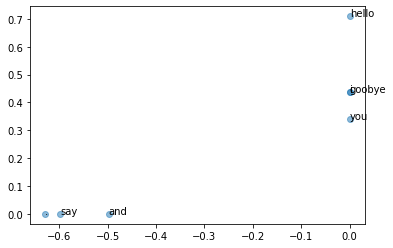

In [ ]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [ ]:
class Ptb:
    def __init__(self):
        self.url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
        self.key_file = {
            'train':'ptb.train.txt',
            'test':'ptb.test.txt',
            'valid':'ptb.valid.txt'
        }
        self.save_file = {
            'train': 'ptb.train.npy',
            'test': 'ptb.test.npy',
            'valid': 'ptb.valid.npy'
        }
        self.vocab_file = 'ptb.vocab.pkl'
        self.dataset_dir = os.path.dirname(os.path.abspath('/content/drive/MyDrive/Colab Notebooks/zero2_chap02.ipynb'))

    
    def _download(self, file_name):
        file_path = self.dataset_dir + '/' + file_name
        if os.path.exists(file_path):
            return

        print('Downloading ' + file_name + ' ... ')

        try:
            urllib.request.urlretrieve(self.url_base + file_name, file_path)
        except urllib.error.URLError:
            import ssl
            ssl._create_default_https_context = ssl._create_unverified_context
            urllib.request.urlretrieve(self.url_base + file_name, file_path)

        print('Done')


    def load_vocab(self):
        vocab_path = self.dataset_dir + '/' + self.vocab_file

        if os.path.exists(vocab_path):
            with open(vocab_path, 'rb') as f:
                word_to_id, id_to_word = pickle.load(f)
            return word_to_id, id_to_word
        
        word_to_id = {}
        id_to_word = {}
        data_type = 'train'
        file_name = self.key_file[data_type]
        file_path = self.dataset_dir + '/' + file_name

        self._download(file_name)

        words = open(file_path).read().replace('\n', '<eos>').strip().split()

        for i, word in enumerate(words):
            if word not in word_to_id:
                tmp_id = len(word_to_id)
                word_to_id[word] = tmp_id
                id_to_word[tmp_id] = word
        
        with open(vocab_path, 'wb') as f:
            pickle.dump((word_to_id, id_to_word), f)

        return word_to_id, id_to_word

    
    def load_data(self, data_type='train'):
        if data_type == 'val': data_type = 'valid'
        save_path = self.dataset_dir + '/' + self.save_file[data_type]

        word_to_id, id_to_word = self.load_vocab()

        if os.path.exists(save_path):
            corpus = np.load(save_path)
            return corpus, word_to_id, id_to_word

        file_name = self.key_file[data_type]
        file_path = self.dataset_dir + '/' + file_name
        self._download(file_name)

        words = open(file_path).read().replace('\n', '<eos>').strip().split()
        corpus = np.array([word_to_id[w] for w in words])

        np.save(save_path, corpus)
        return corpus, word_to_id, id_to_word

In [ ]:
ptb = Ptb()
for data_type in ('train', 'val', 'test'):
    ptb.load_data(data_type)

In [ ]:
%%time
window_size = 2
wordvec_size = 100
corpus, word_to_id, id_to_word = Ptb().load_data('train')
vocab_size = len(word_to_id)

print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

counting  co-occurrence ...
calculating PPMI ...
1.0 done
2.0 done
3.0 done
4.0 done
5.0 done
6.0 done
7.0 done
8.0 done
9.0 done
10.0 done
11.0 done
12.0 done
13.0 done
14.0 done
15.0 done
16.0 done
17.0 done
18.0 done
19.0 done
20.0 done
21.0 done
22.0 done
23.0 done
24.0 done
25.0 done
26.0 done
27.0 done
28.0 done
29.0 done
30.0 done
31.0 done
32.0 done
33.0 done
34.0 done
35.0 done
36.0 done
37.0 done
38.0 done
39.0 done
40.0 done
41.0 done
42.0 done
43.0 done
44.0 done
45.0 done
46.0 done
47.0 done
48.0 done
49.0 done
50.0 done
51.0 done
52.0 done
53.0 done
54.0 done
55.0 done
56.0 done
57.0 done
58.0 done
59.0 done
60.0 done
61.0 done
62.0 done
63.0 done
64.0 done
65.0 done
66.0 done
67.0 done
68.0 done
69.0 done
70.0 done
71.0 done
72.0 done
73.0 done
74.0 done
75.0 done
76.0 done
77.0 done
78.0 done
79.0 done
80.0 done
81.0 done
82.0 done
83.0 done
84.0 done
85.0 done
86.0 done
87.0 done
88.0 done
89.0 done
90.0 done
91.0 done
92.0 done
93.0 done
94.0 done
95.0 done
96.0 done


In [ ]:
%%time
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.7182652354240417
 we: 0.6270021200180054
 've: 0.5716179013252258
 do: 0.5598205924034119
 'll: 0.5540858507156372

[query] year
 month: 0.7013973593711853
 earlier: 0.6302028298377991
 quarter: 0.605720579624176
 last: 0.5910311341285706
 next: 0.5647600889205933

[query] car
 luxury: 0.647039532661438
 auto: 0.5764955878257751
 truck: 0.500117838382721
 corsica: 0.4579145312309265
 cars: 0.441764235496521

[query] toyota
 motor: 0.7586854696273804
 nissan: 0.6616930365562439
 honda: 0.6334963440895081
 motors: 0.6171403527259827
 chevrolet: 0.5849233269691467
CPU times: user 1.72 s, sys: 213 ms, total: 1.93 s
Wall time: 1.63 s
